##### Imports & Settings

In [25]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [26]:
%matplotlib inline

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt


DATA = Path('./data')
# DATA_STORE = DATA / 'data.h5'
DATA_READ = DATA / 'data.h5'

In [27]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

##### Load Data

In [28]:
with pd.HDFStore(DATA_READ) as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

##### Select Investment Universe

In [29]:
data = data[data.dollar_vol_rank < 100]

In [30]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102252 entries, ('A', Timestamp('2013-10-15 00:00:00')) to ('ZTS', Timestamp('2017-11-29 00:00:00'))
Data columns (total 65 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   volume                  102252 non-null  float64
 1   dollar_vol              102252 non-null  float64
 2   dollar_vol_1m           102252 non-null  float64
 3   dollar_vol_rank         102252 non-null  float64
 4   rsi                     102252 non-null  float64
 5   bb_high                 102252 non-null  float64
 6   bb_low                  102252 non-null  float64
 7   atr                     102252 non-null  float64
 8   macd                    102252 non-null  float64
 9   return_1d               102252 non-null  float64
 10  return_5d               102252 non-null  float64
 11  return_10d              102252 non-null  float64
 12  return_21d              102252 non-null  float64
 13  r

##### Create Model Data

In [31]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', \
            'volume'], axis=1)

In [32]:
y

target_1d  target_5d  target_10d  target_21d
ticker date                                                    
A      2013-10-15   0.013365   0.000550    0.001600    0.000299
       2013-10-16   0.021140  -0.003555   -0.000798   -0.000951
       2013-10-17   0.006458  -0.005881   -0.003649    0.002021
       2013-10-18  -0.018871  -0.004263   -0.003625    0.000944
       2013-10-21  -0.018657  -0.001931   -0.001511    0.001649
...                      ...        ...         ...         ...
ZTS    2017-11-22   0.003096   0.003410    0.000799    0.000613
       2017-11-24   0.003507   0.002818    0.000825    0.000696
       2017-11-27  -0.002097  -0.001458    0.000321    0.000602
       2017-11-28   0.003082  -0.001517    0.001170    0.000663
       2017-11-29   0.009496  -0.001794    0.001070    0.000285

[102252 rows x 4 columns]

##### Explore Data

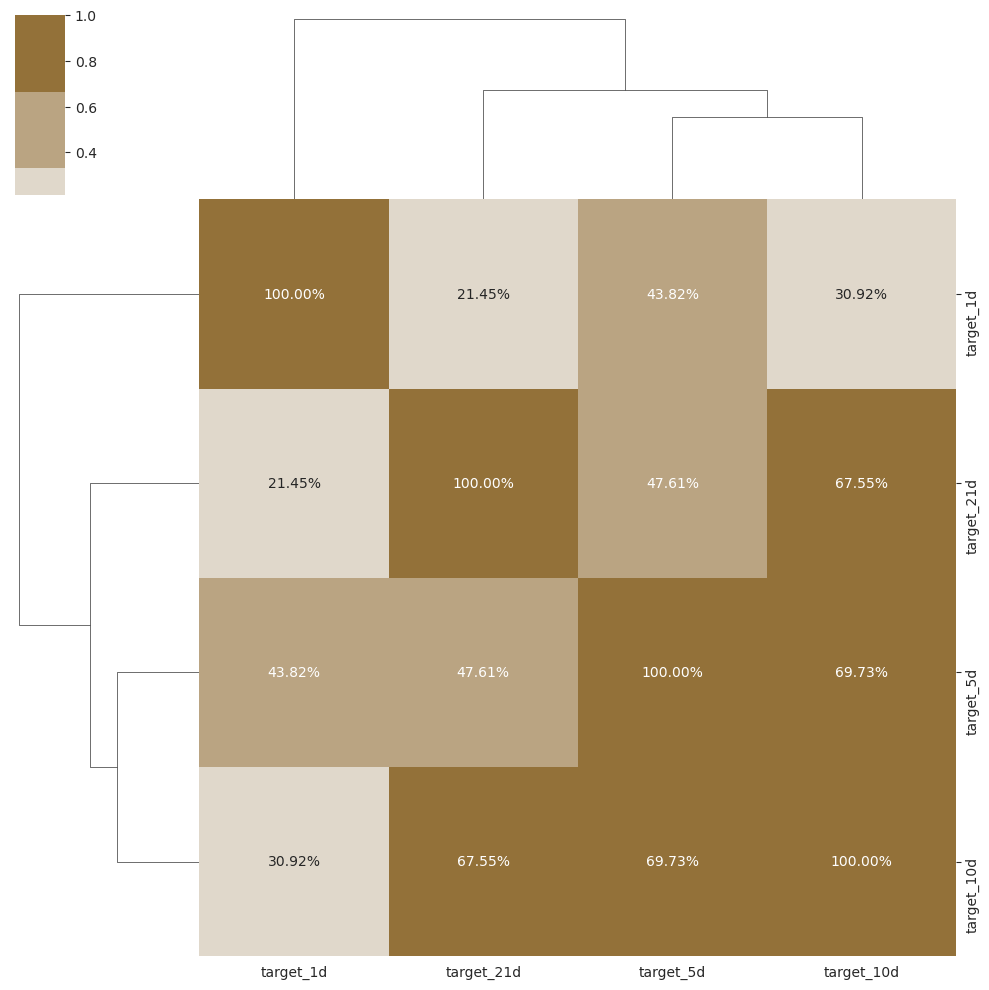

In [33]:
sns.clustermap(y.corr(), 
    cmap=sns.diverging_palette(h_neg=220, h_pos=55, s=75, l=50),
    center=0, annot=True, fmt='.2%')

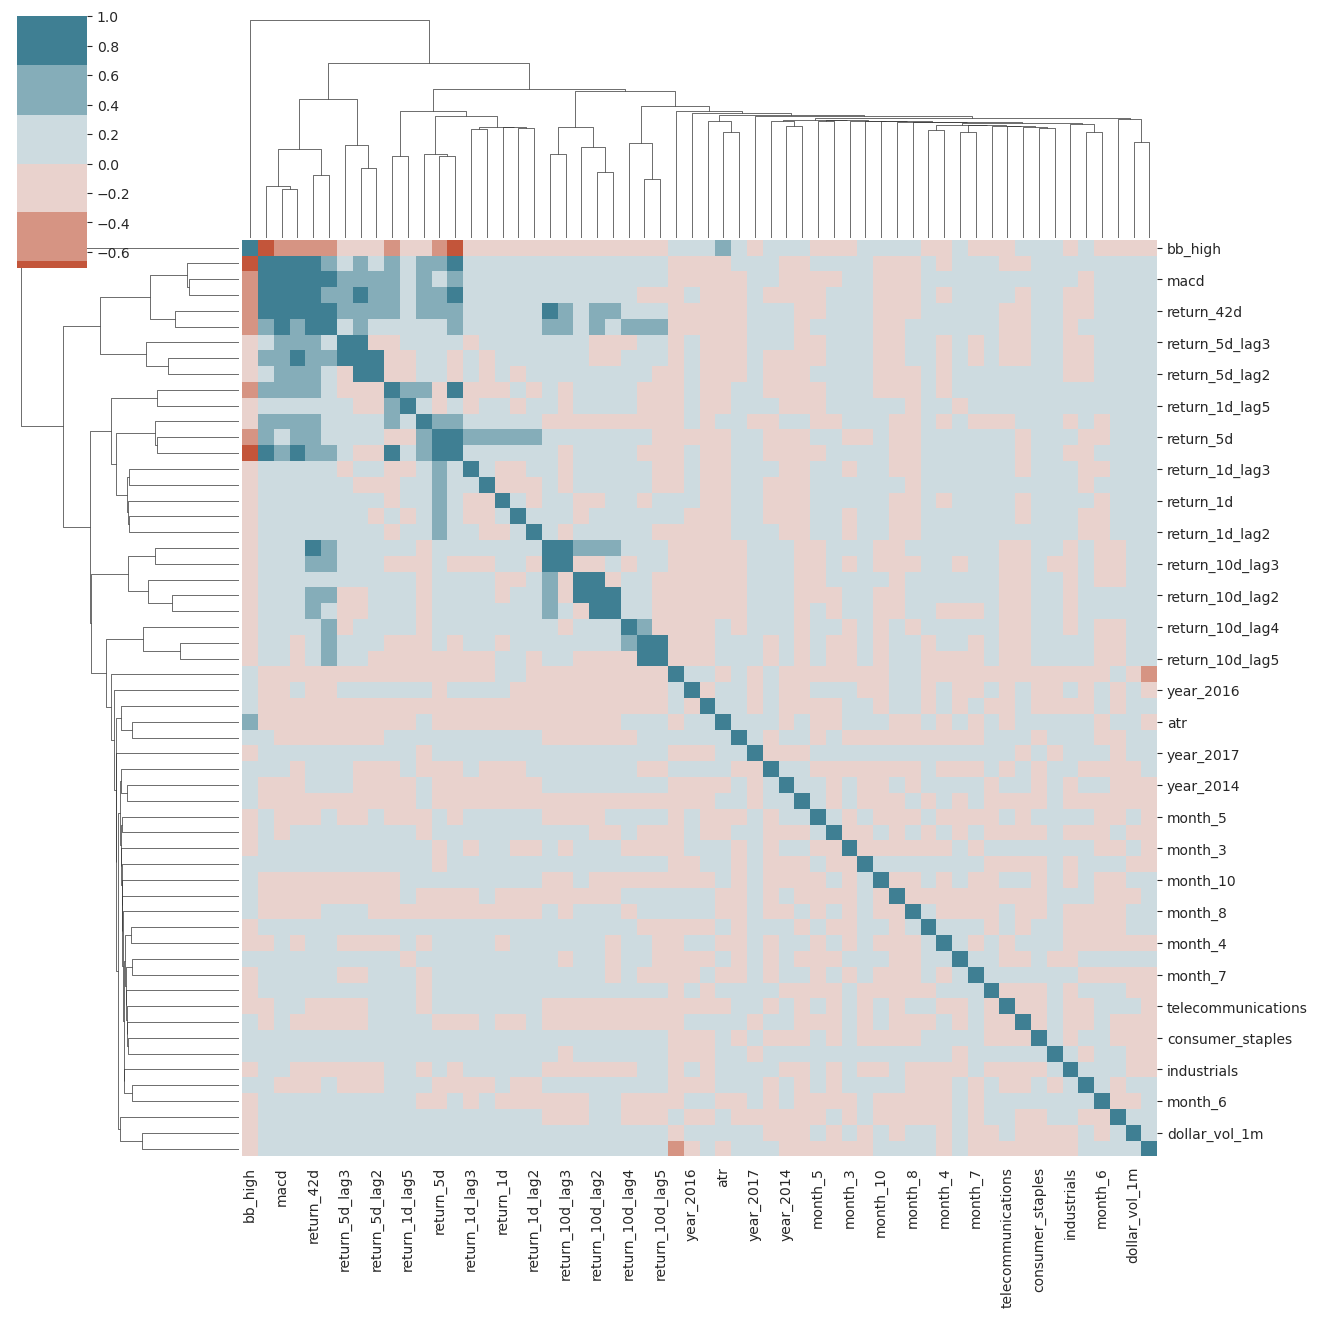

In [34]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [35]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1 \
    != corr_mat.var2].sort_values(by='corr', ascending=False)

In [36]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
648,return_63d,return_42d,0.842163
591,return_42d,return_63d,0.842163
291,macd,rsi,0.820857
63,rsi,macd,0.820857
527,return_21d,macd,0.807926
524,return_21d,bb_high,-0.639494
124,bb_high,return_10d,-0.694139
466,return_10d,bb_high,-0.694139
60,rsi,bb_high,-0.710776
117,bb_high,rsi,-0.710776


<Axes: >

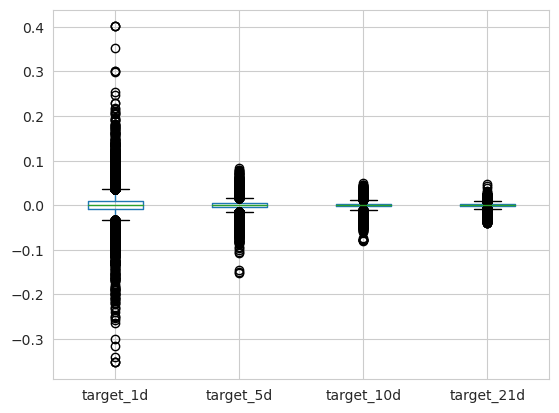

In [37]:
y.boxplot()

##### Linear Regression for Statistical Inference: OLS with statsmodels

- Ticker-wise standardization
statsmodels warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [38]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
     .join(sectors)
     .fillna(0))

##### 1-Day Returns

In [39]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     13.56
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.52e-125
Time:                        12:44:22   Log-Likelihood:             2.5442e+05
No. Observations:              102252   AIC:                        -5.087e+05
Df Residuals:                  102194   BIC:                        -5.082e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

##### 10-Day Returns

In [40]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     81.03
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:25:26   Log-Likelihood:             3.7636e+05
No. Observations:              102252   AIC:                        -7.526e+05
Df Residuals:                  102194   BIC:                        -7.521e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

##### Monthly Returns

In [41]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     124.2
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:49:24   Log-Likelihood:             4.1612e+05
No. Observations:              102252   AIC:                        -8.321e+05
Df Residuals:                  102194   BIC:                        -8.316e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0